# <font color=darkcyan> Variational inference </font>
#### <font color=darkorange>Basics: Evidence Lower Bound (ELBO) & Coordinate Ascent Variational Inference (CAVI) </font>

In [10]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

<font color=darkred>Mixture of Gaussian distributions.</font>

Following ``Variational Inference: A Review for Statisticians, Blei et al; (2017)``, consider a Bayesian mixture of unit-variance univariate Gaussians. 

There are $K$ mixture components, each component $k$ of the mixture is a Gaussian distribution with mean $\mu_k$ and variance 1. The random variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ are assumed to be independent and identically distributed (i.i.d.) with Gaussian distribution with mean 0 and variance $\sigma^2$. The weight of each mixture component $k$ written $\omega_k$. Conditionally on $\mu$, the observations $(X_i)_{1\leqslant i\leqslant n}$ are assumed to be i.i.d. with probability density:

$$
p(x|\mu) = \sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x)\,,
$$

where $\varphi_{\mu_k,\sigma^2}$ is the Gaussian probability function with mean $\mu_k$ and variance $\sigma^2$. The likelihood is then given by:

$$
p(x_1,\cdots,x_n) = \int p(x_1,\cdots,x_n|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n p(x_i|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n \left(\sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x_i)\right) p(\mu) \mathrm{d} \mu
$$

Application with $K= 3$, $\sigma^2 = 5$, $\omega_k = 1/K$ for all $1\leqslant k \leqslant K$.

In [11]:
# Sample data
K  = 3 # number of mixture components
mu = np.random.normal(0, np.sqrt(5), K) # means of the distribution in each cluster
n_samples = 1000 # number of samples

In [12]:
mu

array([ 1.24317034,  1.99563228, -0.94432465])

<font color=darkcyan> **Note charles**
The more numpythonic way of sampling data is working with arrays directly instead of loops. It's faster, and in many cases will be mandatory for automatic differentiation and fast parallelisation.

In [13]:
idx = np.random.randint(0, K, n_samples)
np.random.seed(0)
# here mu[idx], when idx is an integer array, returns an array of the mu values indexed by idx
X = np.random.normal(0, 1, n_samples) + mu[idx] # On tire notre dataset

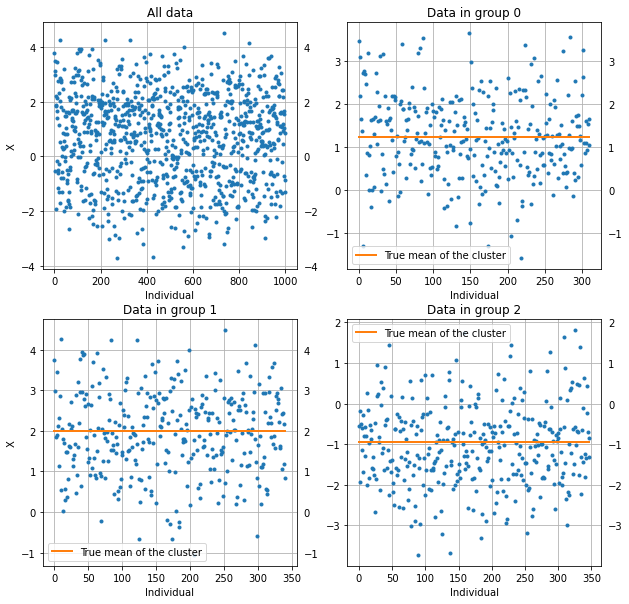

In [14]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(X, '.')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('All data')
plt.subplot(2,2,2)
plt.plot(X[idx==0], '.')
plt.plot(np.arange(np.size(X[idx==0])),mu[0]*np.ones(np.size(X[idx==0])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 0')
plt.legend()
plt.subplot(2,2,3)
plt.plot(X[idx==1], '.')
plt.plot(np.arange(np.size(X[idx==1])),mu[1]*np.ones(np.size(X[idx==1])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('Data in group 1')
plt.legend()
plt.subplot(2,2,4)
plt.plot(X[idx==2], '.')
plt.plot(np.arange(np.size(X[idx==2])),mu[2]*np.ones(np.size(X[idx==2])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 2')
plt.legend()

Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations.  The mean-field variational family is described as follows:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i)\,, 
$$

which means that:

- $\mu$ and $c$ are independent.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ are independent with Gaussian distribution with means $(m_{k})_{1\leqslant k \leqslant K}$ and variances $(s_{k})_{1\leqslant k \leqslant K}$.
- $(c_{i})_{1\leqslant i \leqslant n}$ are independent with multinomial distribution with parameters $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ for $1\leqslant k \leqslant K$. 

Write $\mathcal{D}$ the family of such distributions when $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^K$, variances $(s_{k})_{1\leqslant k \leqslant K}\in (\mathbb{R}_+^*)^K$ and $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ where $\mathcal{S}_K$ is the $K$-dimensional probability simplex. 

The objective is now to find the
"best candidate" in $\mathcal{D}$ to approximate $p(\mu,c|x)$, i.e. the one ``which minimizes the following KL divergence``:

$$
q^* = \mathrm{Argmin}_{q\in\mathcal{D}} \mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right)\,.
$$

Note that
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

where the ``Evidence Lower Bound`` (ELBO) is

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

Therefore, ``minimizing the KL divergence`` boils down to maximizing the ELBO, where $\log p(x)\geqslant \mathrm{ELBO}(q)$.

The complexity of the family $\mathcal{D}$ determines the complexity of the optimization.

<font color=darkred>Generic CAVI algorithm.</font>

The CAVI algorithm updates iteratively the marginal distribution of each variables, for instance, 

\begin{align*}
\mathrm{ELBO}(q) &= -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,,\\
&= -\mathbb{E}_{q_{\mu_k}}[\log q_{\mu_k}(\mu_k)] + \mathbb{E}_{q_{\mu_k}}[\mathbb{E}_q[\log p(\mu,c,x)|\mu_k]] \,,\\
&= -\mathbb{E}_{q_{\mu_k}}[\log q_{\mu_k}(\mu_k)] + \mathbb{E}_{q_{\mu_k}}[\mathbb{E}_{q_{\bar \mu_k}}[\log \tilde p_k(\mu_k|x)]] + C \,,\\
\end{align*}


Therefore, the algorithm computes iteratively for all $1\leqslant k \leqslant K$,

$$
q(\mu_k) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)]\right)
$$

and, similarly,  for all $1\leqslant i \leqslant n$,

$$
q(c_i) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right)\,,
$$

where 

- $\tilde p_i(c_i|x)$ is the conditional distribution of $c_i$ given the observations and all the other parameters and $\tilde p_k(\mu_k|x)$ is the conditional distribution of $\mu_k$ given the observations and all the other parameters.

- $\mathbb{E}_{\tilde q_z}$ is the expectation under the variational law of all parameters except $z$.

<font color=darkred>Application to the mixture of Gaussian distributions.</font>

As $\tilde p_i(c_i|x)$ be the conditional distribution of $c_i$ given the observations and the other parameters.

$$
\tilde p_i(c_i|x) \propto p(c_i)p(x_i|c_i,\mu) \propto p(c_i)\prod_{k=1}^K \left(\varphi_{\mu_k,1}(x_i)\right)^{1_{c_i=k}}\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)] = \log p(c_i) + \sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right) &\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,.
\end{align*}

The update is then written:

$$
\varphi_i(k) \propto p(c_i=k) \mathrm{exp}\left(m_k x_i - \frac{m^2_k + s_k}{2}\right)\,.
$$

<font color=darkred> Update of $(\phi_i)_{1\leqslant i \leqslant n}$ using CAVI.</font>

In [34]:
# Calcul des phi_i(k)
def CAVI_update_phi(X, m, s2):
    
    first_term_mean = np.outer(X, m) # Calcul des mk*xi
    second_term_mean = -(m**2 + s2)/2 # Calcul du terme en (mk**2 + sk) / 2
    
    phi = np.exp(first_term_mean + second_term_mean[np.newaxis, :]) # On ajoute un axe à second_term_mean
    phi = phi / phi.sum(1)[:, np.newaxis] # phi.sum(1) somme les valeurs sur l'axe 1, permet certainement de diviser par K (car p(ci=k)=1/K)
    
    return phi

As $\tilde p_k(\mu_k|x)$ be the conditional distribution of $\mu_k$ given the observations and the other parameters.

$$
\tilde p_k(\mu_k|x) \propto p(\mu_k)\prod_{i=1}^np(x_i|c_i,\mu) \propto p(\mu_k)\prod_{i=1}^n p(x_i|\mu,c_i)\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)] = \log p(\mu_k) + \sum_{i=1}^n \mathbb{E}_{\tilde q_{\mu_k}}[\log p(x_i|\mu,c_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_i(c_i|x)]\right) &\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n\sum_{k=1}^K  \mathbb{E}_{\tilde q_{\mu_k}}[1_{c_i=k}\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n \phi_i(k) \mathbb{E}_{\tilde q_{\mu_k}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}-\frac{1}{2}\sum_{i=1}^n \phi_i(k)(x_i-\mu_k)^2\right)\,,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}+\sum_{i=1}^n \phi_i(k)x_i\mu_k - \frac{1}{2}\sum_{i=1}^n \phi_i(k)\mu^2_k\right)\,.
\end{align*}

The update is then written:

$$
m_k = \frac{\sum_{i=1}^n \phi_i(k)x_i}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\quad\mathrm{and}\quad s_k = \frac{1}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\,. 
$$

<font color=darkred> Update of $(m_{k})_{1\leqslant k \leqslant K}$ and $(s_{k})_{1\leqslant k \leqslant K}$ using CAVI.</font>

In [16]:
# Calcul des mk et sk
def CAVI_update_mu_s2(X, m, phi, s2, sigma2, K):
    
    m  = (phi*X[:, np.newaxis]).sum(0) * (1/sigma2 + phi.sum(0))**(-1)
    s2 = (1/sigma2 + phi.sum(0))**(-1)
    
    return m, s2

In [17]:
# Correspond à la ELBO sans les constantes (termes ne dépendant pas des paramètres de la loi q, soit s2, m et phi).
# Les termes en sigma2 et X ne sont là que parce qu'ils sont multipliés aux paramètres de la loi
def elbo(X, phi, m, s2, sigma2):
        
        first_term  = (0.5*np.log(s2) - 0.5*(m**2+s2)/sigma2).sum()
        second_term = (-0.5*(s2+m**2) + np.outer(X, m) - np.log(phi))*phi

        return first_term + second_term.sum()

In [18]:
def CAVI_mixture_Gaussian(X, m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-8):
        ###
        # X : les observations x_i
        # m : l'initialisation des moyennes (les m_k, "variational parameters") de la loi de q
        # phi : l'initialisation des phi_i ("variational parameters") de la loi de q
        # sigma2 : l'initialisation des {s_k}^2 ("variational parameters") de la loi de q
        # max_iter : le nombre maximal d'itérations de l'algorithme CAVI (l'algo peut s'arrêter avant si critère de convergence vérifié)
        # epsilon : la précision à atteindre pour la convergence de l'algo CAVI (écart entre la dernière ELBO et l'avant-dernière)
        # return : la liste des elbos, la matrice des moyennes estimées de q, la matrice des variances estimées de q
        ###
        
        elbos  = [elbo(X, phi, m, s2, sigma2)] # On initialise la première ELBO
        m_est  = [m] # On initialise la matrice des moyennes estimées pour la loi q
        s2_est = [s2] # On initialise la matrice des variances estimées de la loi q
        
        for it in range(1, max_iter+1): # Pour chaque itération
            
            phi   = CAVI_update_phi(X,m,s2) # On met à jour phi
            m, s2 = CAVI_update_mu_s2(X,m,phi,s2,sigma2,K) # On met à jour moyenne et variance estimées
            
            m_est.append(m) # On ajoute la moyenne estimée à la liste des moyennes estimées
            s2_est.append(s2) # On ajoute la variance estimée à la liste des variances estimées
            
            elbos.append(elbo(X, phi, m, s2, sigma2)) # On ajoute la ELBO calculée à la liste des ELBO

            if np.abs(elbos[-2] - elbos[-1]) <= epsilon: # Si l'écart entre la dernière ELBO calculée et l'avant-dernière est plus petit qu'epsilon
                break # On arrête les itérations
        
        return elbos, m_est, s2_est

<font color=darkred> Run the algorithm.</font>

In [19]:
# Initialization
# On initialise les proba d'appartenance à chaque cluster pour chaque donnée (matrice de n_samples lignes et K colonnes)
phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
# On initialise les moyennes de chaque cluster avec la loi normale centrée réduite (vecteur de taille K)
m_init = np.random.normal(0, 1, K)
# On initialise les variances pour chaque cluster (variances de la moyenne de chaque cluster) selon une loi uniforme sur [0;1[ (vecteur de taille K)
s2_init = np.ones(K) * np.random.random(K)

In [21]:
print(phi_init)
print(m_init)
print(s2_init)

[[0.2601531  0.3570703  0.38277661]
 [0.40914079 0.49189463 0.09896458]
 [0.15155576 0.67275776 0.17568648]
 ...
 [0.53859024 0.31756094 0.14384883]
 [0.14602018 0.38025361 0.47372621]
 [0.13752159 0.55727733 0.30520108]]
[-0.34891086  1.54109617  1.90875275]
[0.17687018 0.43903735 0.81903767]


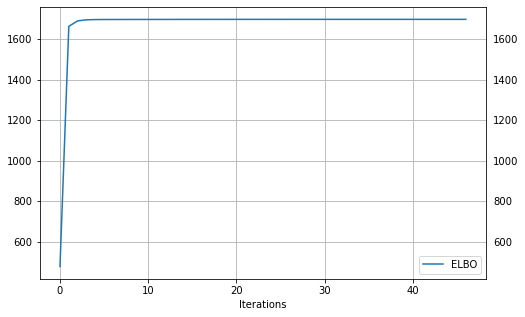

In [23]:
fig = plt.figure(figsize=(8,5))
# On fait tourner l'algorithme CAVI
elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

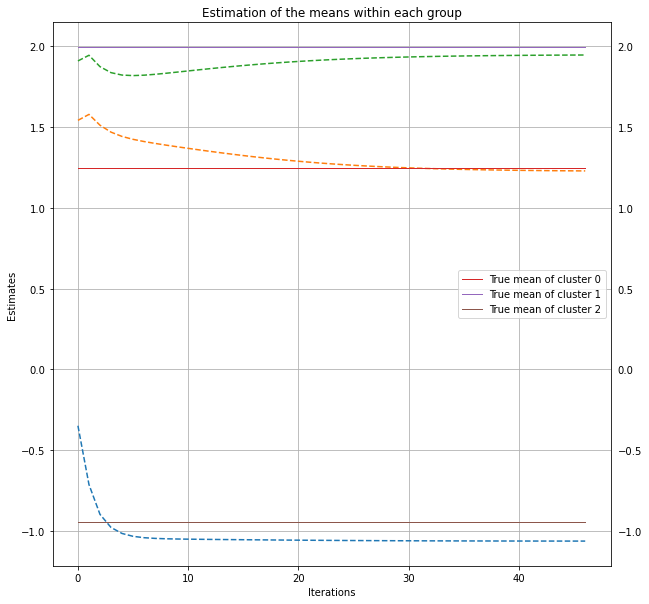

In [26]:
# Convergence of the estimators
nb_iter = np.array(elbos).size # number of iterations before stopping criterion
fig = plt.figure(figsize=(10,10))
plt.plot(m_est, '--')
plt.plot(np.arange(nb_iter),mu[0]*np.ones(nb_iter), linewidth=1, label = 'True mean of cluster 0')
plt.plot(np.arange(nb_iter),mu[1]*np.ones(nb_iter), linewidth=1, label = 'True mean of cluster 1')
plt.plot(np.arange(nb_iter),mu[2]*np.ones(nb_iter), linewidth=1, label = 'True mean of cluster 2')
plt.tick_params(labelright=True)
plt.legend()
plt.grid(True)
plt.ylabel('Estimates')
plt.xlabel('Iterations')
plt.title('Estimation of the means within each group');

Text(0, 0.5, 'Posterior probability density of the means')

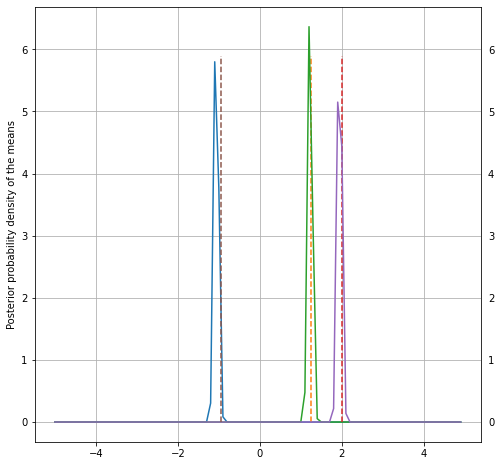

In [28]:
# Posterior distribution of the means in each group
from scipy.stats import norm
plt.figure(figsize=(8,8))
x_axis = np.arange(-5, 5, 0.1)
y_axis = np.arange(0, 6, 0.1)
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][0],np.sqrt(s2_est[-1][0]))) # Moyenne estimée du cluster 0
plt.plot(mu[0]*np.ones(np.size(y_axis)), y_axis, '--') # Vraie moyenne du cluster 0
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][1],np.sqrt(s2_est[-1][1])))
plt.plot(mu[1]*np.ones(np.size(y_axis)), y_axis, '--')
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][2],np.sqrt(s2_est[-1][2])))
plt.plot(mu[2]*np.ones(np.size(y_axis)), y_axis, '--')
plt.tick_params(labelright=True)
plt.grid(True)
plt.ylabel('Posterior probability density of the means')

In [29]:
# m_est contient la liste des estimations de la moyenne au cours du temps donc on prend la dernière qui est censée être la meilleure
m_est[-1] # Attention l'ordre peut être est différent de celui de départ

array([-1.06274371,  1.22819483,  1.94554194])

In [30]:
mu

array([ 1.24317034,  1.99563228, -0.94432465])

In [31]:
s2_est[-1]

array([0.00295925, 0.00301834, 0.00301415])

<font color=darkred> Sensitivity to initialization.</font>

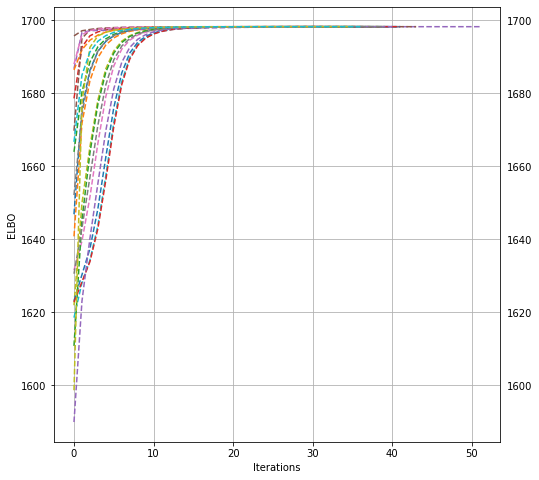

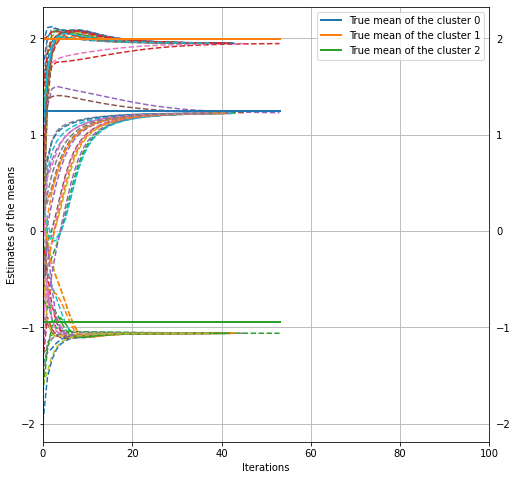

In [32]:
nb_iter_max = 0
for _ in range(20): # On teste 20 initialisation différentes
    # Initialization
    phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
    m_init = np.random.normal(0, 1, K)
    s2_init = np.ones(K) * np.random.random(K)
    elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
    nb_iter = np.array(elbos).size
    if nb_iter>nb_iter_max:
        nb_iter_max = nb_iter
    plt.figure(0, figsize=(8,8))
    plt.plot(np.array(elbos[2::]), '--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.figure(1, figsize=(8,8))
    plt.plot(m_est,'--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('Estimates of the means')

plt.figure(1)
plt.xlim([0,100])
plt.plot(np.arange(nb_iter_max),mu[0]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 0')
plt.plot(np.arange(nb_iter_max),mu[1]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 1')
plt.plot(np.arange(nb_iter_max),mu[2]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 2')
plt.legend()

In [33]:
elbos

[-110.94689006274346,
 1575.9176584139661,
 1666.7217419357378,
 1684.9870154717953,
 1691.335770404364,
 1694.2714372752448,
 1695.8189265825995,
 1696.6981524368014,
 1697.2255769005978,
 1697.5559648508618,
 1697.7703525879544,
 1697.9135460663426,
 1698.0114957297912,
 1698.0798402997075,
 1698.1283292682783,
 1698.1632195163393,
 1698.1886278865927,
 1698.2073222196861,
 1698.2211986575514,
 1698.2315776660332,
 1698.2393921459172,
 1698.245309585472,
 1698.2498129326934,
 1698.2532550768497,
 1698.255896130815,
 1698.2579293071499,
 1698.2594991086225,
 1698.2607142646061,
 1698.2616570277019,
 1698.2623899182286,
 1698.2629606592714,
 1698.2634058158135,
 1698.263753497081,
 1698.2640253759741,
 1698.264238206778,
 1698.264404971686,
 1698.2645357509214,
 1698.264638385849,
 1698.264718986218]